# 🔍 TinyGlassNet 推理 Notebook

快速演示如何使用训练得到的 TinyGlassNet checkpoint / ONNX 模型，对缓存的 mel 样本做前向推理。

## ✅ 流程介绍
1. 配置：指定 index 路径、checkpoint/ONNX 路径、采样数量。
2. 数据：从 balanced index 抽样背景 & glass，加载 mel tensor 批次。
3. 推理：分别用 PyTorch 模型与 ONNXRuntime 执行前向，比较输出。
4. 可视化：查看每个样本的预测概率，辅助人工验证。

In [1]:
# Cell: Imports & Helper bindings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from src.config import SEED
from src.datasets import load_index_df
from src.inference import (
    load_torch_checkpoint,
    load_mel_batch,
    run_torch_inference,
    create_onnx_session,
    run_onnx_inference,
)

sns.set_theme(style="whitegrid")
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


## ⚙️ 配置

In [2]:
# Cell: Configuration
INDEX_PATH = Path("cache/index_balanced.parquet")
if not INDEX_PATH.exists():
    INDEX_PATH = Path("cache/index_balanced.csv")

CHECKPOINT_PATH = Path("cache/experiments/tinyglassnet_best.pt")
ONNX_PATH = Path("cache/experiments/tinyglassnet_best.onnx")
LABEL_MAP = {0: "background", 1: "glass_breaking"}
SAMPLES_PER_LABEL = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
THRESHOLD = 0.5

print(f"Using checkpoint: {CHECKPOINT_PATH}")
print(f"ONNX path: {ONNX_PATH}")


Using checkpoint: cache/experiments/tinyglassnet_best.pt
ONNX path: cache/experiments/tinyglassnet_best.onnx


## 📁 加载索引并抽样

In [3]:
# Cell: Load index & sample per label
index_df = load_index_df(INDEX_PATH)
print(f"Loaded {len(index_df)} cached entries")

samples = []
for label in sorted(index_df['label'].unique()):
    subset = index_df[index_df['label'] == label]
    if subset.empty:
        continue
    take = min(SAMPLES_PER_LABEL, len(subset))
    sampled = subset.sample(take, random_state=SEED)
    samples.append(sampled)
sampled_df = pd.concat(samples, ignore_index=True)
sampled_df = sampled_df.reset_index(drop=True)
display(sampled_df[['label', 'path']])


Loaded 1166 cached entries


,label,path
0,background,/workspace/cache/mel64/background/fold5/5-1801...
1,background,/workspace/cache/mel64/background/fold2/2-1164...
2,background,/workspace/cache/mel64/background/fold5/5-2148...
3,glass,/workspace/cache/mel64/glass/fold4/4-204115-A-...
4,glass,/workspace/cache/mel64/glass/fold5/5-260433-A-...
5,glass,/workspace/cache/mel64/glass/fold5/5-221529-A-...


## 🧠 PyTorch 推理

In [4]:
# Cell: Torch inference
from src.config import LABEL_TO_ID

model, payload = load_torch_checkpoint(CHECKPOINT_PATH, device=DEVICE)
batch = load_mel_batch(sampled_df)
torch_result = run_torch_inference(model, batch, DEVICE, threshold=None)

glass_idx = LABEL_TO_ID.get("glass", 0)
probs = torch_result.probs.numpy()
if glass_idx >= probs.shape[1]:
    raise ValueError(f"Glass idx {glass_idx} out of bounds for probs shape {probs.shape}")
prob_glass = probs[:, glass_idx]
pred_glass = (prob_glass >= THRESHOLD).astype(int)
pred_label = np.where(pred_glass == 1, "glass", "background")

pred_df = sampled_df.copy()
pred_df["prob_glass"] = prob_glass
pred_df["pred_glass"] = pred_glass
pred_df["pred_label"] = pred_label
display(pred_df[["label", "pred_label", "prob_glass", "path"]])


,label,pred_label,prob_glass,path
0,background,background,0.135888,/workspace/cache/mel64/background/fold5/5-1801...
1,background,background,0.131125,/workspace/cache/mel64/background/fold2/2-1164...
2,background,background,0.267775,/workspace/cache/mel64/background/fold5/5-2148...
3,glass,glass,0.999641,/workspace/cache/mel64/glass/fold4/4-204115-A-...
4,glass,glass,0.999715,/workspace/cache/mel64/glass/fold5/5-260433-A-...
5,glass,glass,0.999721,/workspace/cache/mel64/glass/fold5/5-221529-A-...


## 🧾 ONNX 推理（可选）

In [5]:
# Cell: ONNX inference comparison
if ONNX_PATH.exists():
    session = create_onnx_session(ONNX_PATH)
    onnx_result = run_onnx_inference(session, batch.cpu())
    delta = torch.abs(torch_result.probs - onnx_result.probs).max().item()
    print(f"Max prob delta between Torch and ONNX: {delta:.6f}")
else:
    print("ONNX file not found; skip ONNX inference.")


Max prob delta between Torch and ONNX: 0.000000


## 📊 概览可视化

/tmp/ipykernel_1045/1773101616.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(pred_df['pred_label'], rotation=45, ha='right')


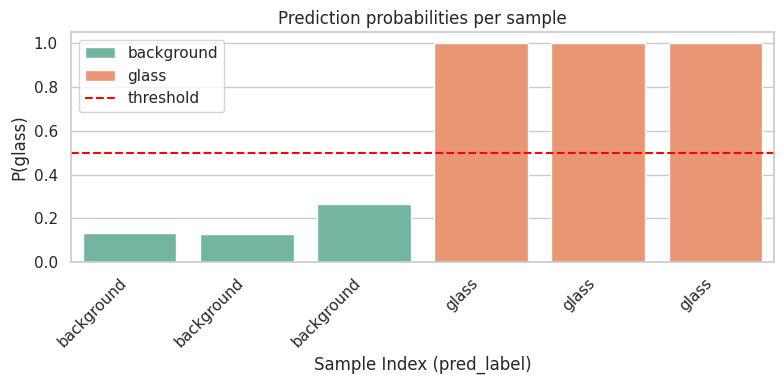

In [6]:
# Cell: Probability plot
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    data=pred_df,
    x=np.arange(len(pred_df)),
    y='prob_glass',
    hue='label',
    palette='Set2',
    ax=ax,
)
ax.set_xticklabels(pred_df['pred_label'], rotation=45, ha='right')
ax.axhline(THRESHOLD, color='red', linestyle='--', label='threshold')
ax.set_xlabel('Sample Index (pred_label)')
ax.set_ylabel('P(glass)')
ax.set_title('Prediction probabilities per sample')
ax.legend()
plt.tight_layout()


## ✅ 后续方向
- 替换样本为真实现场音频切片，验证端到端链路。
- 在此 Notebook 中集成音频播放器/可视化，进行更细的 QA。
- 将推理结果封装为 CLI/脚本，方便批量验证。